In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/squad-datathon-2025/sample_submission.csv
/kaggle/input/squad-datathon-2025/train.csv
/kaggle/input/squad-datathon-2025/test.csv


# This notebook is divided into 7 sections

### 1. Reading the data
- Insights from data reading

### 2. Cleaning, Visualizing and Pre-Processing
#### 2.1. Target balance
#### 2.2. Missing Imputation
   1. **Numerical Missing Imputation (X19)**
      - Analysis
      - Fix
   2. **Categorical Missing Imputation (X5)**
      - Analysis
      - Fix
#### 2.3. Checking Duplicate Rows & Columns
#### 2.4. Low Variance Feature Removal

### Treating Categorical columns
#### 2.5. Categorical Relation with respect to target and other variables (Chi-Square Test)
   - Analysis
   - Fix
#### 2.6. Outlier in Numerical Columns and Their Treatment
   - Analysis
   - Fix
#### 2.7. Numerical Correlation
   - Analysis
   - **Fix**: Combining and dropping to avoid redundancy
#### 2.8. Analysis with respect to Date (Month and Year)
   - Analysis

### 3. Statistical Feature Enrichment
#### Reasoning

#### 3.1. Creating Features
#### 3.2. Keeping only valid columns and dropping the rest (correlation, category, date-based)
   - **Reason and Discussion**:
     1. Dropping Columns Based on Weak Correlation
     2. Dropping Categorical Columns

### 4. Splitting Data into Train-Validation

### 5. Normalizing Data Using Standard Scaler

### 6. Modeling
#### 6.1. Model Selection
- Data is highly imbalanced, so using classifiers that can handle weights and imbalances.
  - Logistic Regression, Random Forest, Neural Network
#### 6.2. Hyperparameter Tuning
- I will tune Random Forest
#### 6.3. Final Model: Neural Network
- Optimizer: SGD, batch size: 64, class_weight={0: 1.0, 1: 3.0}
- **Detailed Discussion**:

### 7. Prediction on Test Data
#### 7.1. Reading the Test Data
#### 7.2. Preprocessing Based on Section 2
#### 7.3. Column Sorting Based on Section 3
#### 7.4. Using Standard Scaler as per Section 5
#### 7.5. Prediction Using the Final Model
#### 7.6. Saving Data in CSV


In [157]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency
from scipy.stats import skew
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD


# 1. Reading the data

In [158]:
train_df=pd.read_csv("/kaggle/input/squad-datathon-2025/train.csv")
train_df.head()

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X11,X12,X13,X14,X15,X16,X17,X18,X19,Y
0,256039,3600.0,a,7.37,b,a,b,62004.0,a,Feb-2009,...,3.50,6.0,0.0,5514.0,19.5,20.0,b,a,NaN,0
1,176486,12000.0,b,16.49,e,g,b,143000.0,a,Nov-2014,...,14.03,14.0,1.0,5808.0,75.4,36.0,a,a,1.0,0
2,392670,8500.0,b,11.49,a,b,b,27000.0,a,Jun-2010,...,0.89,12.0,0.0,449.0,2.0,22.0,b,a,NaN,1
3,46168,3725.0,a,10.99,a,l,a,14916.0,c,Nov-2015,...,32.42,14.0,0.0,6557.0,23.9,26.0,a,a,0.0,0
4,313821,28000.0,a,15.41,e,a,a,100000.0,b,Dec-2015,...,9.91,11.0,1.0,17499.0,53.2,29.0,b,a,0.0,1


In [159]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316824 entries, 0 to 316823
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      316824 non-null  int64  
 1   X1      316824 non-null  float64
 2   X2      316824 non-null  object 
 3   X3      316824 non-null  float64
 4   X4      316824 non-null  object 
 5   X5      316824 non-null  object 
 6   X6      316824 non-null  object 
 7   X7      316824 non-null  float64
 8   X8      316824 non-null  object 
 9   X9      316824 non-null  object 
 10  X10     316824 non-null  object 
 11  X11     316824 non-null  float64
 12  X12     316824 non-null  float64
 13  X13     316824 non-null  float64
 14  X14     316824 non-null  float64
 15  X15     316594 non-null  float64
 16  X16     316824 non-null  float64
 17  X17     316824 non-null  object 
 18  X18     316824 non-null  object 
 19  X19     286594 non-null  float64
 20  Y       316824 non-null  int64  
dtypes: float64

In [160]:
#checking percentage of null values in each column
train_df_missing=pd.DataFrame((round(100*(train_df.isnull().sum()/len(train_df.index)), 2)), columns=['missing'])
train_df_missing.sort_values(by=['missing'], ascending=False).head(20)

,missing
X19,9.54
X15,0.07
ID,0.00
X11,0.00
X18,0.00
X17,0.00
X16,0.00
X14,0.00
X13,0.00
X12,0.00


In [161]:
#here i am getting the discrete values that each column holds
df_unique = train_df.nunique().to_frame().reset_index()
df_unique.columns = ['Variable','DistinctCount']
df_unique

,Variable,DistinctCount
0,ID,316824
1,X1,1388
2,X2,2
3,X3,564
4,X4,7
5,X5,12
6,X6,6
7,X7,22896
8,X8,3
9,X9,115


In [162]:
# Separate numerical and categorical columns
categorical_cols = train_df.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_cols = train_df.select_dtypes(include=["number"]).columns.tolist()

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Categorical Columns: ['X2', 'X4', 'X5', 'X6', 'X8', 'X9', 'X10', 'X17', 'X18']
Numerical Columns: ['ID', 'X1', 'X3', 'X7', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X19', 'Y']


In [163]:
# Display unique values for each categorical column 
for col in categorical_cols:
    print(f"\n{'-'*50}\nColumn: {col}")
    unique_values = train_df[col].unique()
    print(f"Unique Values ({len(unique_values)}):")
    for value in unique_values:
        print(f"  - {value}")


--------------------------------------------------
Column: X2
Unique Values (2):
  - a
  - b

--------------------------------------------------
Column: X4
Unique Values (7):
  - b
  - e
  - a
  - c
  - f
  - g
  - d

--------------------------------------------------
Column: X5
Unique Values (12):
  - a
  - g
  - b
  - l
  - i
  - e
  - f
  - j
  - d
  - h
  - c
  - k

--------------------------------------------------
Column: X6
Unique Values (6):
  - b
  - a
  - c
  - d
  - e
  - f

--------------------------------------------------
Column: X8
Unique Values (3):
  - a
  - c
  - b

--------------------------------------------------
Column: X9
Unique Values (115):
  - Feb-2009
  - Nov-2014
  - Jun-2010
  - Nov-2015
  - Dec-2015
  - May-2011
  - Mar-2013
  - Sep-2013
  - Jul-2014
  - Jun-2014
  - Jul-2012
  - Jul-2011
  - May-2016
  - Apr-2013
  - Oct-2013
  - May-2014
  - Aug-2014
  - Jan-2014
  - Jul-2013
  - Dec-2013
  - Aug-2013
  - Jun-2013
  - May-2015
  - Nov-2011
  - Sep-2015


In [164]:
#trying to look deeper into the numerical columns
train_df.describe()

,ID,X1,X3,X7,X11,X12,X13,X14,X15,X16,X19,Y
count,316824.000000,316824.000000,316824.000000,3.168240e+05,316824.000000,316824.000000,316824.000000,3.168240e+05,316594.000000,316824.000000,286594.000000,316824.000000
mean,197905.081979,14115.958545,13.638893,7.418979e+04,17.356240,11.311974,0.178206,1.585640e+04,53.780322,25.417932,1.815520,0.196128
std,114380.629129,8357.466328,4.468187,6.011999e+04,8.649246,5.141122,0.535613,2.079702e+04,24.428614,11.894787,2.150931,0.397067
min,1.000000,500.000000,5.320000,6.000000e+02,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,98842.750000,8000.000000,10.490000,4.500000e+04,11.280000,8.000000,0.000000,6.023000e+03,35.800000,17.000000,0.000000,0.000000
50%,197695.000000,12000.000000,13.330000,6.400000e+04,16.910000,10.000000,0.000000,1.118550e+04,54.800000,24.000000,1.000000,0.000000
75%,297049.250000,20000.000000,16.490000,9.000000e+04,22.980000,14.000000,0.000000,1.960900e+04,72.900000,32.000000,3.000000,0.000000
max,396029.000000,40000.000000,30.990000,8.706582e+06,1622.000000,90.000000,86.000000,1.743266e+06,153.000000,151.000000,34.000000,1.000000


In [165]:
unique_values = train_df['Y'].unique()
print(unique_values)

[0 1]


### **Insights from data reading**:
By Reading the data we know till now that 
1. Column X19 is numeric and has 10% data missing, and X5 is Categorical and have 0.07% of missing data.
2. X9 is a column with date values and various ways can be explored further.
3. It is a binary classification problem as the 'Y' column has 0 and 1.

# 2.Cleaning, Visualizing and Pre-Processing

## 2.1 Target Balanace 

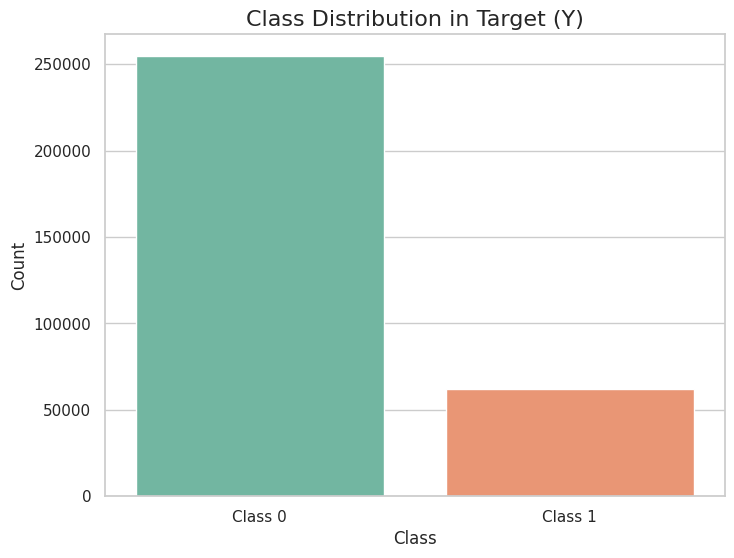

In [166]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Y', data=train_df, palette='Set2')

plt.title("Class Distribution in Target (Y)", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['Class 0', 'Class 1'])  
plt.show()

It is highly imbalaced and will be handelled  at last

## 2.2 Missing Value Imputation

### 1. Numerical Missing Imputation (X19)

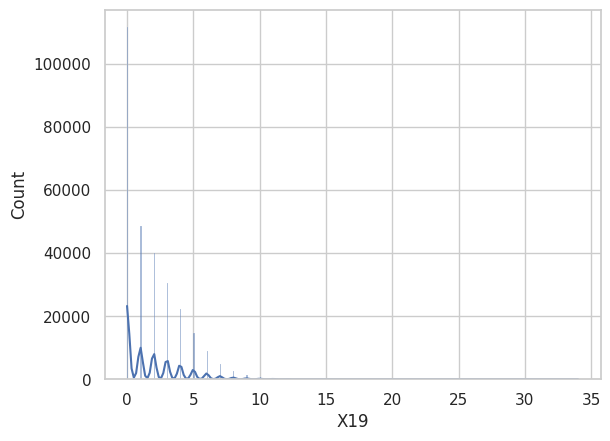

In [167]:
sns.histplot(train_df['X19'], kde=True)
plt.show()


**Anaysis**: Since the distribution is positively skewed and 10%, median imputation is generally the best choice. The median is less sensitive to outliers and skewed distributions than the mean, and it will better represent the central tendency of the data without being influenced by extreme values in the tail.

### Fix

In [168]:
imputer = SimpleImputer(strategy='median')
train_df['X19'] = imputer.fit_transform(train_df[['X19']])

In [169]:
missing_percent_after = train_df['X19'].isnull().mean() * 100
print(f"Missing data percentage after imputation: {missing_percent_after}%")

Missing data percentage after imputation: 0.0%


### 2.Categorical Missing Imputation (X5)

**Analysis**: From dataset reading I know, X5 has categorical data with 12 unique values, and the missing percentage is very low (0.07%), therefore I am using mode imputation

### Fix

In [170]:
imputer = SimpleImputer(strategy='most_frequent')
train_df['X5'] = imputer.fit_transform(train_df[['X5']]).ravel()  # Flatten to 1D

missing_percent_after_x5 = train_df['X5'].isnull().mean() * 100
print(f"Missing data percentage for X5 after imputation: {missing_percent_after_x5:.2f}%")

most_frequent_value = imputer.statistics_[0]
print(f"Most frequent (mode) value used for imputation: {most_frequent_value}")

unique_values = train_df['X5'].unique()
print(f"Unique values in 'X5' after imputation: {unique_values}")

Missing data percentage for X5 after imputation: 0.00%
Most frequent (mode) value used for imputation: a
Unique values in 'X5' after imputation: ['a' 'g' 'b' 'l' 'i' 'e' 'f' 'j' 'd' 'h' 'c' 'k']


## 2.3 Checking Duplicate Rows & Columns

In [171]:
duplicate_count = train_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")


Number of duplicate rows: 0


In [172]:
def find_duplicate_columns(df):
    duplicates = []
    cols = df.columns
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            if df[cols[i]].equals(df[cols[j]]):
                duplicates.append((cols[i], cols[j]))
    return duplicates

duplicate_columns = find_duplicate_columns(train_df)
if duplicate_columns:
    print("Duplicate columns found:")
    for col1, col2 in duplicate_columns:
        print(f"'{col1}' is a duplicate of '{col2}'")
else:
    print("No duplicate columns found.")

No duplicate columns found.


## 2.4 Low Variance Feature Removal

**Analysis** :
For categorical columns, if a column has 85% or more of the same value, it lacks the necessary variability to be useful for prediction. A feature with high uniformity, such as one with a single dominant category, doesn't provide new insights into the relationships between the target variable and the other features.

Also for numerical columns, if a column has 85% or more of the same value, it suggests the column has very low variance. A numerical feature with little to no variation doesn’t carry much predictive value for the target variable. Such columns may either be constant or contain very few unique values, limiting their usefulness in building an accurate model.

So I will remove them, I am not including ID, Date and Target 'Y'

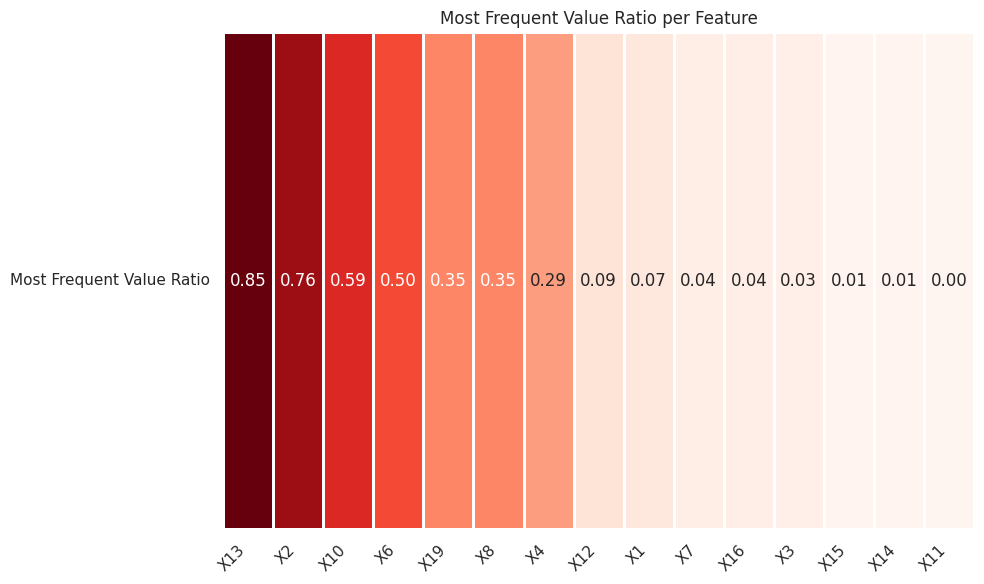

Columns dropped due to low variance (≥85% same value): ['X13']
Remaining columns in the dataset: ['ID', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'Y']


In [173]:
# Defining columns (excluding ID, date X9, and target Y)
categorical_columns = ['X2', 'X4', 'X6', 'X8', 'X10']
numerical_columns = ['X1', 'X3', 'X7', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X19']

# Function to calculate most frequent value ratio per column
def get_most_frequent_value_ratios(df, columns):
    col_ratios = {}
    for col in columns:
        ratio = df[col].value_counts(normalize=True).max()
        col_ratios[col] = ratio
    return col_ratios


cat_ratios = get_most_frequent_value_ratios(train_df, categorical_columns)
num_ratios = get_most_frequent_value_ratios(train_df, numerical_columns)


all_ratios = {**cat_ratios, **num_ratios}
ratio_df = pd.DataFrame.from_dict(all_ratios, orient='index', columns=['Most Frequent Value Ratio'])
ratio_df = ratio_df.sort_values(by='Most Frequent Value Ratio', ascending=False)

# Plotting 
plt.figure(figsize=(10, 6))
sns.heatmap(ratio_df.T, cmap='Reds', annot=True, cbar=False, linewidths=1, fmt=".2f")
plt.title('Most Frequent Value Ratio per Feature')
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Dropping columns with ≥ 85% same value
low_variance_cols = ratio_df[ratio_df['Most Frequent Value Ratio'] >= 0.85].index.tolist()
train_df.drop(columns=low_variance_cols, inplace=True)

print(f"Columns dropped due to low variance (≥85% same value): {low_variance_cols}")
print("Remaining columns in the dataset:", list(train_df.columns))

## 2.5 Categorical Relation wrt to target and other variables,(chi square test)

In [174]:
categorical_columns = ['X2', 'X4', 'X5', 'X6', 'X8', 'X10', 'X17', 'X18']  # X9 excluded because it is date
target = 'Y'  # Target column

def chi_square_test(df, columns, target_col):
    result_list = []
    
    # Comparing each categorical feature with the target
    for col in columns:
        table = pd.crosstab(df[col], df[target_col])
        chi2, _, _, _ = chi2_contingency(table)
        chi2_formatted = f"{chi2:.2f}" if chi2 >= 0.01 else f"{chi2:.2e}"
        result_list.append((col, target_col, chi2, chi2_formatted))
    
    # Comparing each pair of categorical features
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col1, col2 = columns[i], columns[j]
            table = pd.crosstab(df[col1], df[col2])
            chi2, _, _, _ = chi2_contingency(table)
            chi2_formatted = f"{chi2:.2f}" if chi2 >= 0.01 else f"{chi2:.2e}"
            result_list.append((col1, col2, chi2, chi2_formatted))
    
    df_results = pd.DataFrame(result_list, columns=["Variable 1", "Variable 2", "Chi2 Value", "Formatted"])
    df_results = df_results.sort_values(by="Chi2 Value", ascending=False).reset_index(drop=True)
    return df_results

df_results = chi_square_test(train_df, categorical_columns, target)
df_results[["Variable 1", "Variable 2", "Formatted"]]

,Variable 1,Variable 2,Formatted
0,X2,X4,68943.62
1,X4,Y,21117.33
2,X4,X8,16188.28
3,X2,X8,15131.84
4,X4,X10,15074.60
5,X5,X6,15057.18
6,X6,X10,11505.28
7,X5,X8,10187.82
8,X2,Y,9487.21
9,X2,X17,3365.26


**Analysis** : The features X4, X2, X8, X10, and X6 show a strong relationship with the target Y. X4 has a significantly high Chi-Square value of 21117.33, indicating a very strong relationship with the target. X2 also shows a substantial association with Y, having a Chi-Square value of 9487.21. Other features like X8 (2385.02) and X10 (1066.18) also exhibit meaningful relationships with the target. X6 with a Chi-Square value of 1574.87 suggests a moderate connection. These features are strongly related to Y and should be retained for further modeling as they can contribute valuable insights.

On the other hand, the features X5, X17, and X18 show weak relationships with the target Y. X5 has a low Chi-Square value of 706.90, indicating minimal association with the target. X17 displays an even weaker relationship with Y, with a Chi-Square value of 25.81, which is quite low. Similarly, X18 shows a very weak association with Y, with a Chi-Square value of 44.26. Given these weak relationships, X5, X17, and X18 should be dropped from the dataset, as they are unlikely to add meaningful predictive value for the target.

### Fix

In [175]:
columns_to_drop = ['X5', 'X17', 'X18']
train_df.drop(columns=columns_to_drop, inplace=True)
print(train_df.columns)

Index(['ID', 'X1', 'X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X14', 'X15', 'X16', 'X19', 'Y'],
      dtype='object')


In [176]:
categorical_cols = train_df.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_cols = train_df.select_dtypes(include=["number"]).columns.tolist()

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Categorical Columns: ['X2', 'X4', 'X6', 'X8', 'X9', 'X10']
Numerical Columns: ['ID', 'X1', 'X3', 'X7', 'X11', 'X12', 'X14', 'X15', 'X16', 'X19', 'Y']


## 2.6 Outlier in numerical column and their treatment

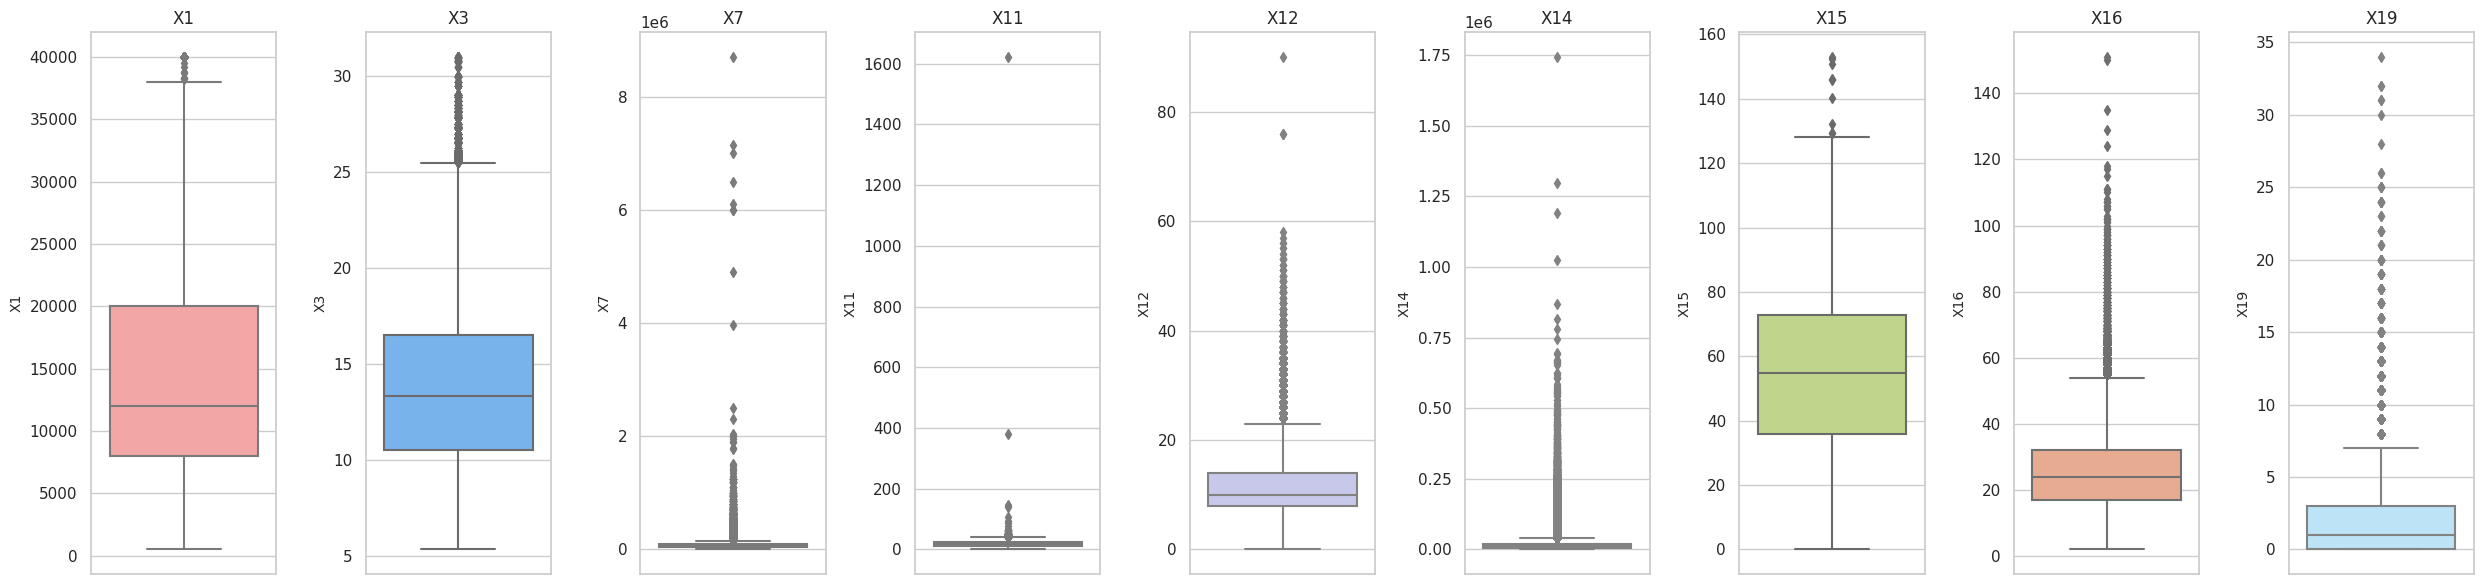

In [177]:
numerical_cols = ['X1', 'X3', 'X7', 'X11', 'X12', 'X14', 'X15', 'X16', 'X19']
sns.set_style("whitegrid")
box_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c4e17f', '#f4a582', '#b3e6ff']


fig, axes = plt.subplots(1, len(numerical_cols), figsize=(25, 6))

# Plotting each numerical column
for ax, col, color in zip(axes, numerical_cols, box_colors):
    sns.boxplot(y=train_df[col], ax=ax, color=color)
    ax.set_title(col, fontsize=12)
    ax.set_ylabel(col, fontsize=10)

plt.tight_layout()
plt.show()

**Analysis** : Columns, including X1, X7, X11, X12, X15, X16, and X19, exhibit the presence of outliers, suggesting the need for robust outlier handling techniques. 
Since the meaning of columns is not specified , I will use Iqr to clip outliers.

### Fix

In [178]:
def remove_iqr_outliers(df, numerical_columns):
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

print(f"train_df shape before outlier removal: {train_df.shape}")

numerical_cols = ['X1', 'X3', 'X7', 'X11', 'X12', 'X14', 'X15', 'X16', 'X19']
train_df = remove_iqr_outliers(train_df, numerical_cols)

print(f"train_df shape after outlier removal: {train_df.shape}")


train_df shape before outlier removal: (316824, 17)
train_df shape after outlier removal: (260569, 17)


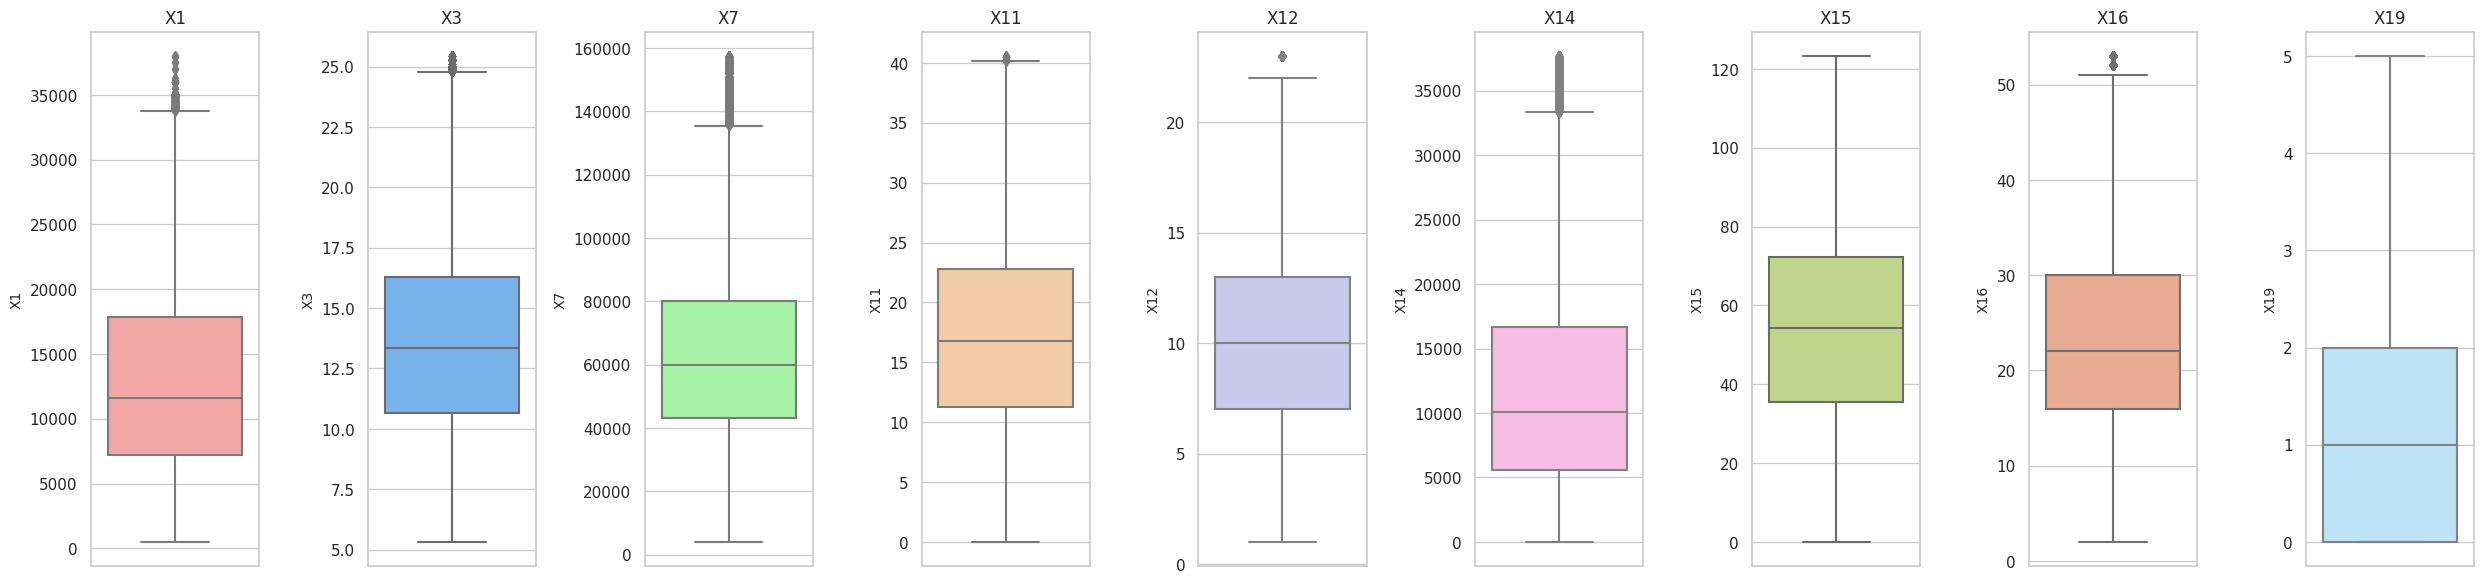

In [179]:
numerical_cols = ['X1', 'X3', 'X7', 'X11', 'X12', 'X14', 'X15', 'X16', 'X19']
sns.set_style("whitegrid")
box_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c4e17f', '#f4a582', '#b3e6ff']


fig, axes = plt.subplots(1, len(numerical_cols), figsize=(25, 6))

# Plotting each numerical column
for ax, col, color in zip(axes, numerical_cols, box_colors):
    sns.boxplot(y=train_df[col], ax=ax, color=color)
    ax.set_title(col, fontsize=12)
    ax.set_ylabel(col, fontsize=10)

plt.tight_layout()
plt.show()

## 2.7 Numerical Correlation

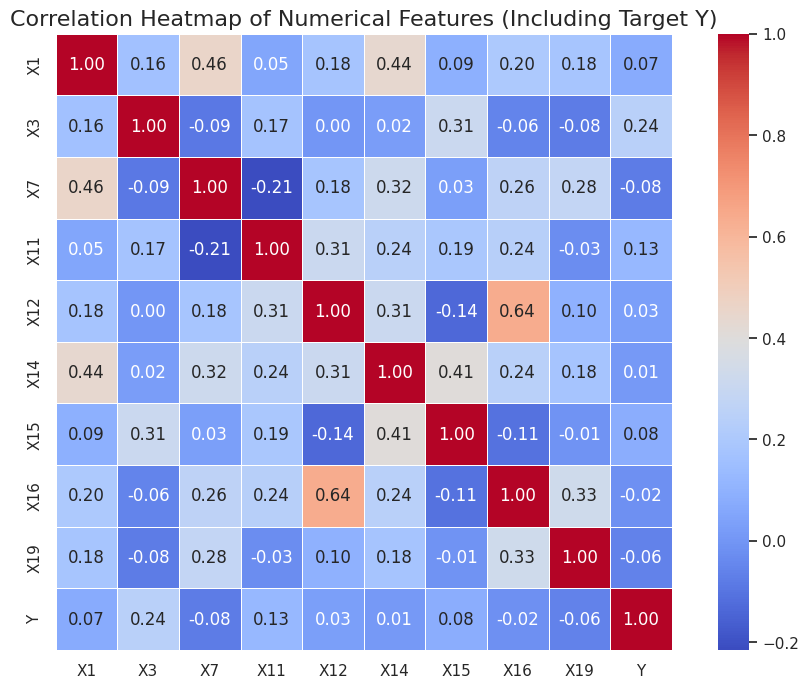

In [180]:
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = [col for col in numerical_cols if col != 'ID']  # Exclude 'ID'

correlation_matrix = train_df[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)
plt.title('Correlation Heatmap of Numerical Features (Including Target Y)', fontsize=16)
plt.show()

**Analysis** : There is no feature strogly correlated with target 'Y' ,and neither with each other except 'X16' and 'X12'.
I am further analyzing the relation between both of them, I would rather combine them to get better result and to avoid redundancy

### Fix: Cobining and dropping to avoid redundancy

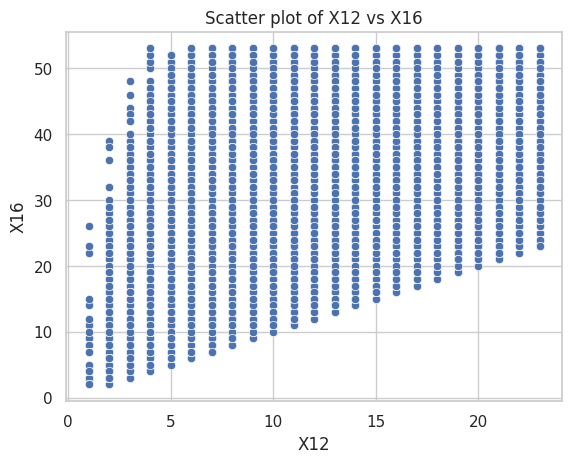

In [181]:
sns.scatterplot(x=train_df['X12'], y=train_df['X16'])
plt.title('Scatter plot of X12 vs X16')
plt.xlabel('X12')
plt.ylabel('X16')
plt.show()

In [182]:
train_df['X12_X16_avg'] = (train_df['X12'] + train_df['X16']) / 2
train_df.drop(['X12', 'X16'], axis=1, inplace=True)
print(train_df.columns)

Index(['ID', 'X1', 'X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X14', 'X15', 'X19', 'Y', 'X12_X16_avg'],
      dtype='object')


## 2.8 Analysis wrt to Date (month and year)

In [183]:
train_df['X9'] = pd.to_datetime(train_df['X9'], format='%b-%Y')  # Format: 'Aug-2015'
train_df['X9_year'] = train_df['X9'].dt.year
train_df['X9_month'] = train_df['X9'].dt.month
train_df.drop(['X9'], axis=1, inplace=True)

In [184]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260569 entries, 0 to 316823
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ID           260569 non-null  int64  
 1   X1           260569 non-null  float64
 2   X2           260569 non-null  object 
 3   X3           260569 non-null  float64
 4   X4           260569 non-null  object 
 5   X6           260569 non-null  object 
 6   X7           260569 non-null  float64
 7   X8           260569 non-null  object 
 8   X10          260569 non-null  object 
 9   X11          260569 non-null  float64
 10  X14          260569 non-null  float64
 11  X15          260569 non-null  float64
 12  X19          260569 non-null  float64
 13  Y            260569 non-null  int64  
 14  X12_X16_avg  260569 non-null  float64
 15  X9_year      260569 non-null  int32  
 16  X9_month     260569 non-null  int32  
dtypes: float64(8), int32(2), int64(2), object(5)
memory usage: 33.8+ MB


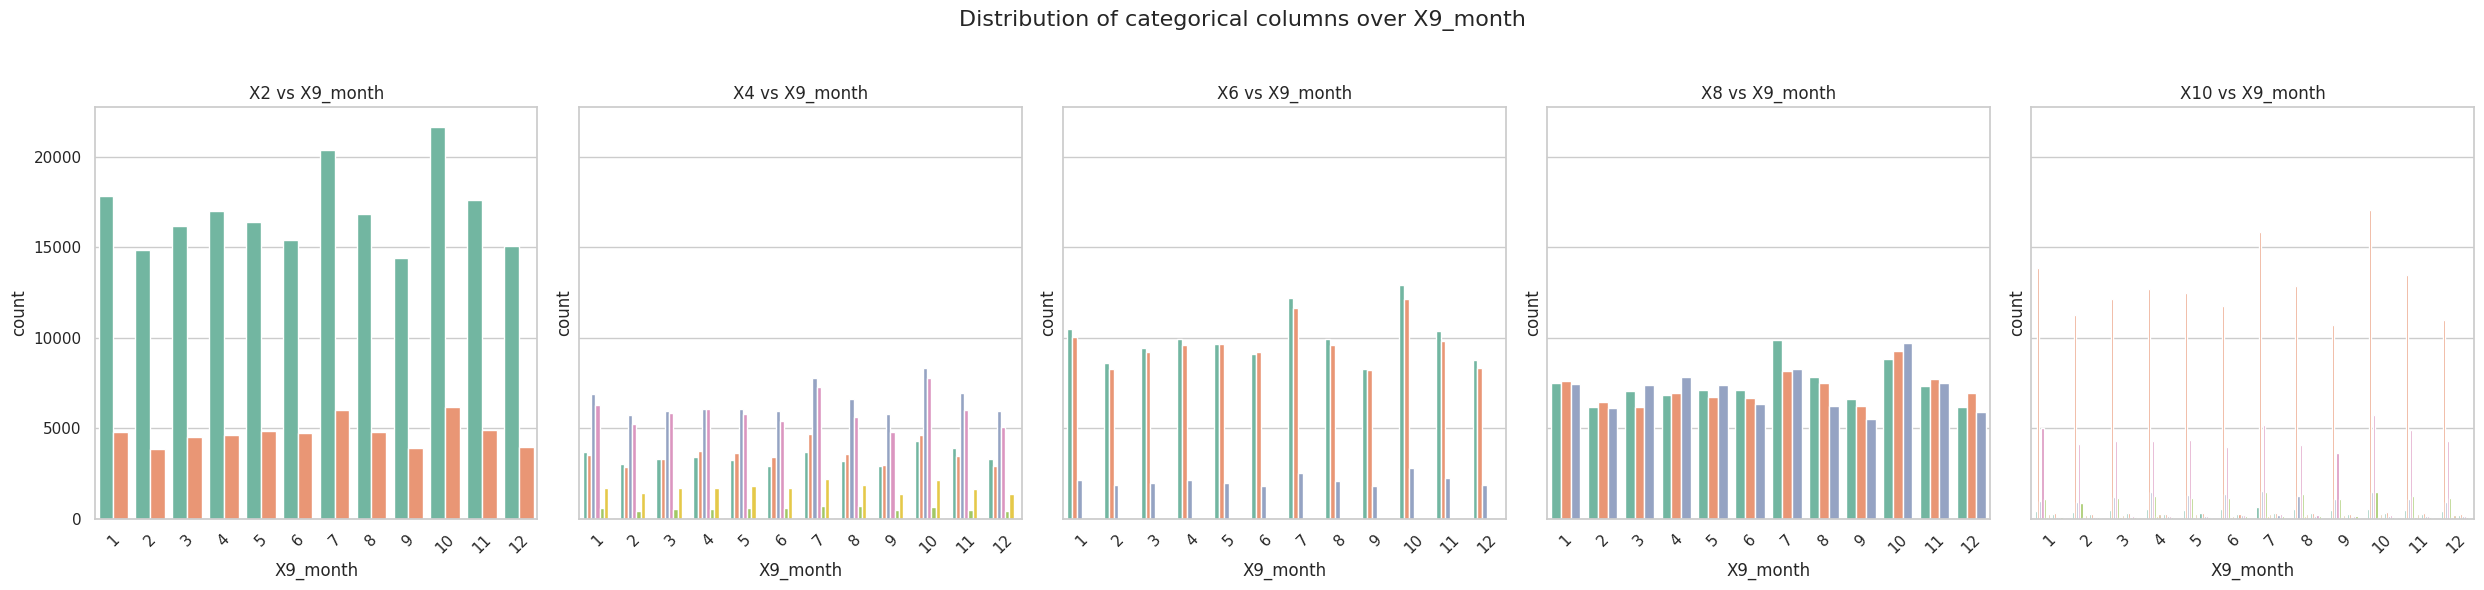

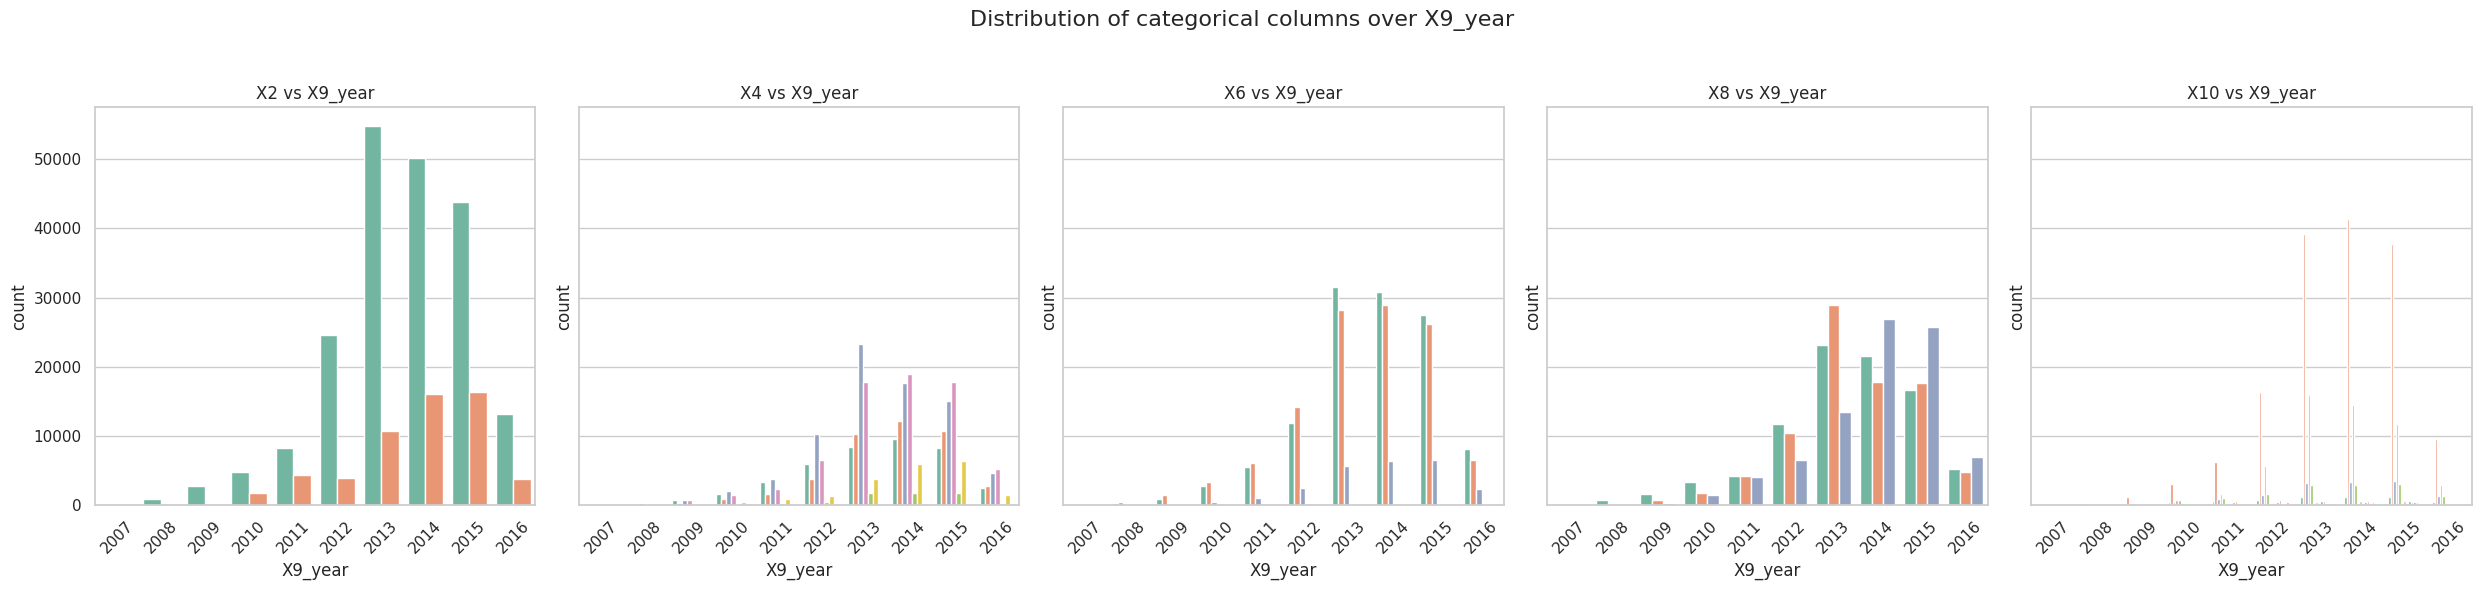

In [185]:
date_parts = ['X9_month', 'X9_year']
categorical_cols = ['X2', 'X4', 'X6', 'X8', 'X10']

# Set plot style
sns.set(style="whitegrid")

for date_col in date_parts:
    fig, axes = plt.subplots(nrows=1, ncols=len(categorical_cols), figsize=(25, 6), sharey=True)
    fig.suptitle(f'Distribution of categorical columns over {date_col}', fontsize=16)

    for i, cat_col in enumerate(categorical_cols):
        sns.countplot(data=train_df, x=date_col, hue=cat_col, ax=axes[i], palette='Set2')
        axes[i].set_title(f'{cat_col} vs {date_col}')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend_.remove()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
    plt.show()

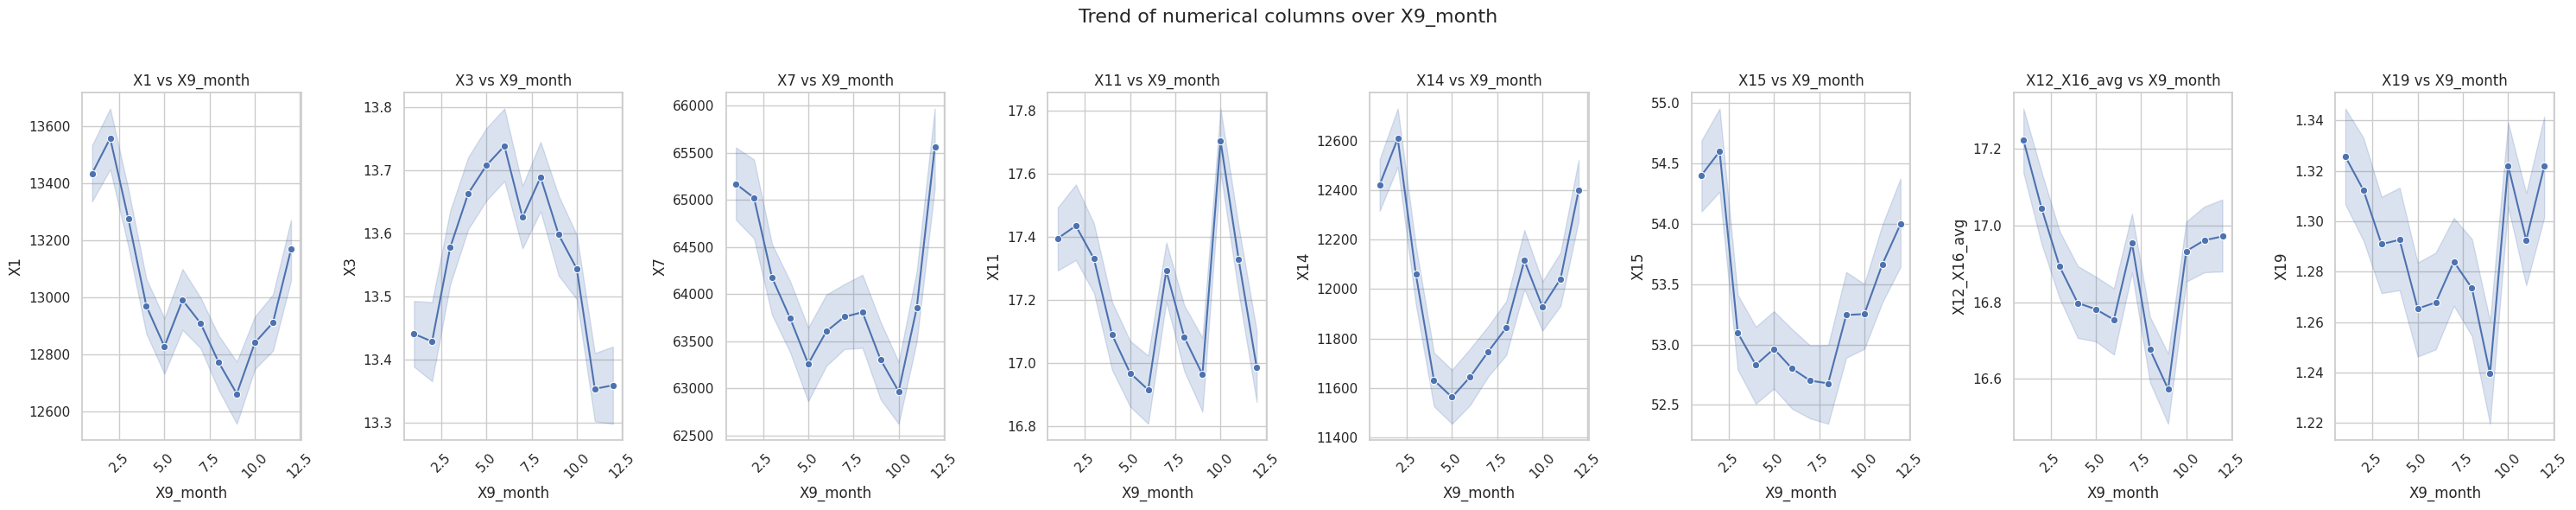

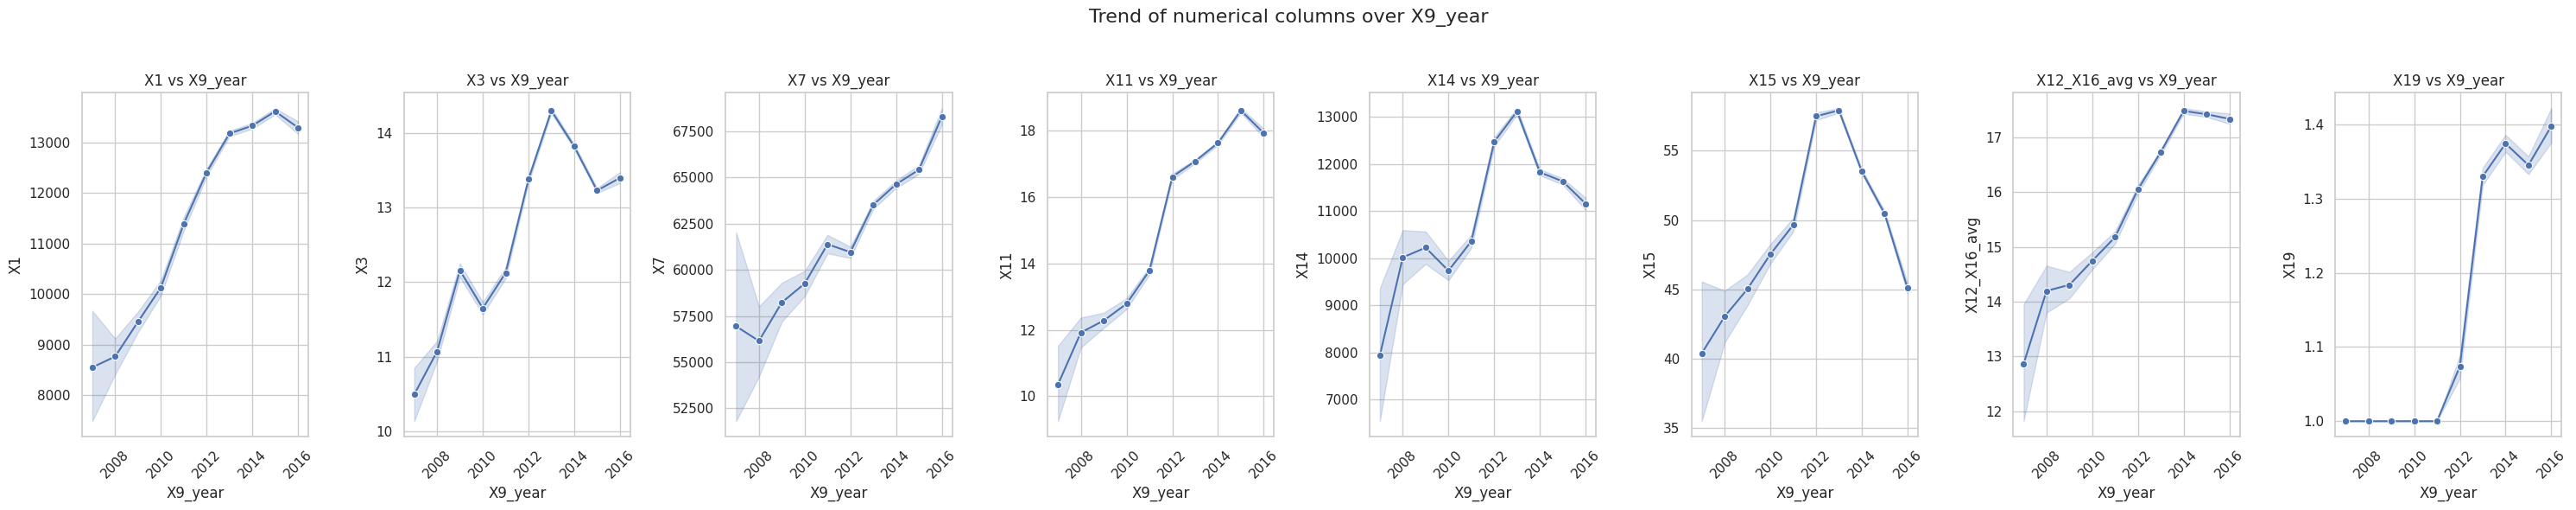

In [186]:
date_parts = ['X9_month', 'X9_year']
numerical_cols = ['X1', 'X3', 'X7', 'X11', 'X14', 'X15','X12_X16_avg', 'X19']  # Excluding 'ID' and 'Y'

sns.set(style="whitegrid")

for date_col in date_parts:
    fig, axes = plt.subplots(nrows=1, ncols=len(numerical_cols), figsize=(30, 6), sharey=False)
    fig.suptitle(f'Trend of numerical columns over {date_col}', fontsize=16)

    for i, num_col in enumerate(numerical_cols):
        sns.lineplot(data=train_df, x=date_col, y=num_col, ax=axes[i], marker="o", color="b")
        axes[i].set_title(f'{num_col} vs {date_col}')
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


**Analysis**: I can see that there are many patterns found with respect to each date related column vs categorical and neumerical column, which indicates that we can create different groups and features wrt to each relation. I will do it in next section

# 3. Statistical Feature Enrichment 

**Reason** : Since the dataset includes many categorical, numerical, and date-related columns without any clear context or explanations, I believe there could be hidden relationships between them. In this section, I use statistical aggregation techniques—such as mean, median, or standard deviation—based on the distribution characteristics of each numerical feature. I group by categorical or date-based columns and map the aggregated values back to create new features. This helps me uncover meaningful patterns and enrich the dataset for better downstream modeling.

## 3.1 Creating Features

In [187]:
# Defining columns (excluding 'ID' and 'Y' from numericals)
numerical_cols = ['X1', 'X3', 'X7', 'X11', 'X12_X16_avg', 'X14', 'X15', 'X19']
categorical_cols = ['X2', 'X4', 'X6', 'X8', 'X10']
date_parts = ['X9_month', 'X9_year']

# Detecting skewness and assign preferred aggregation method
agg_func_map = {}
for col in numerical_cols:
    col_skew = skew(train_df[col].dropna())
    agg_func_map[col] = 'median' if abs(col_skew) > 1 else 'mean'

print("\nSelected aggregation methods for each numerical column:")
for col, method in agg_func_map.items():
    print(f"{col}: {method}")

def create_agg_features(df, group_cols, num_cols, agg_func_map):
    for group_col in group_cols:
        for num_col in num_cols:
            agg_func = agg_func_map[num_col]
            # Creating a mapping from each group value to the aggregated value
            grouped = df.groupby(group_col)[num_col].agg(agg_func).to_dict()
            new_col_name = f'{group_col}_{num_col}_{agg_func}'
            print(f"Creating: {new_col_name} — using {agg_func} of '{num_col}' grouped by '{group_col}'")
            df[new_col_name] = df[group_col].map(grouped)
    return df

# Applying aggregation on both categorical and date-based groupings
train_df = create_agg_features(train_df, categorical_cols + date_parts, numerical_cols, agg_func_map)



Selected aggregation methods for each numerical column:
X1: mean
X3: mean
X7: mean
X11: mean
X12_X16_avg: mean
X14: mean
X15: mean
X19: median
Creating: X2_X1_mean — using mean of 'X1' grouped by 'X2'
Creating: X2_X3_mean — using mean of 'X3' grouped by 'X2'
Creating: X2_X7_mean — using mean of 'X7' grouped by 'X2'
Creating: X2_X11_mean — using mean of 'X11' grouped by 'X2'
Creating: X2_X12_X16_avg_mean — using mean of 'X12_X16_avg' grouped by 'X2'
Creating: X2_X14_mean — using mean of 'X14' grouped by 'X2'
Creating: X2_X15_mean — using mean of 'X15' grouped by 'X2'
Creating: X2_X19_median — using median of 'X19' grouped by 'X2'
Creating: X4_X1_mean — using mean of 'X1' grouped by 'X4'
Creating: X4_X3_mean — using mean of 'X3' grouped by 'X4'
Creating: X4_X7_mean — using mean of 'X7' grouped by 'X4'
Creating: X4_X11_mean — using mean of 'X11' grouped by 'X4'
Creating: X4_X12_X16_avg_mean — using mean of 'X12_X16_avg' grouped by 'X4'
Creating: X4_X14_mean — using mean of 'X14' grouped 

In [188]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260569 entries, 0 to 316823
Data columns (total 73 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         260569 non-null  int64  
 1   X1                         260569 non-null  float64
 2   X2                         260569 non-null  object 
 3   X3                         260569 non-null  float64
 4   X4                         260569 non-null  object 
 5   X6                         260569 non-null  object 
 6   X7                         260569 non-null  float64
 7   X8                         260569 non-null  object 
 8   X10                        260569 non-null  object 
 9   X11                        260569 non-null  float64
 10  X14                        260569 non-null  float64
 11  X15                        260569 non-null  float64
 12  X19                        260569 non-null  float64
 13  Y                          260569 

## 3.2 keeping only valid columns and dropping rest (correlation, category, date based)

### Reason and Discussion:

#### 1. Dropping Columns Based on Weak Correlation:
I am evaluating the correlation of all numerical columns with the target variable (`Y`). Columns that have an absolute correlation value less than 0.1 with the target are considered weakly correlated and are dropped. The rationale behind this decision is that features with weak correlation provide little or no useful information in predicting the target variable and can add noise to the model.

#### 2. Dropping Categorical Columns:
Categorical columns are being dropped from `train_df` because I have already created statistical features derived from them (such as mean, median, etc.). Encoding categorical columns using methods like label encoding or one-hot encoding can introduce issues. Label encoding may assign arbitrary weight to categories, which could introduce bias, while one-hot encoding increases the dimensionality unnecessarily. Since I’ve already used statistical techniques (e.g., group means, medians, etc.) to capture meaningful relationships, further encoding is unnecessary and would add redundancy.


In [189]:
numerical_cols = [col for col in train_df.select_dtypes(include=['number']).columns if col != 'ID']
target_column = 'Y'

# Calculating correlation of each numerical column with the target
correlation_with_target = {}
for col in numerical_cols:
    corr, _ = pearsonr(train_df[col], train_df[target_column])  # Pearson correlation
    correlation_with_target[col] = corr

correlation_df = pd.DataFrame(list(correlation_with_target.items()), columns=['Feature', 'Correlation with Y'])
correlation_df['abs_corr'] = correlation_df['Correlation with Y'].abs()
correlation_df = correlation_df.sort_values(by='abs_corr', ascending=False)
correlation_df



,Feature,Correlation with Y,abs_corr
7,Y,1.000000,1.000000
20,X4_X3_mean,0.251603,0.251603
1,X3,0.242221,0.242221
22,X4_X11_mean,0.238886,0.238886
19,X4_X1_mean,0.221909,0.221909
...,...,...,...
18,X2_X19_median,NaN,NaN
26,X4_X19_median,NaN,NaN
42,X8_X19_median,NaN,NaN
58,X9_month_X19_median,NaN,NaN


In [190]:
print (correlation_df)

                Feature  Correlation with Y  abs_corr
7                     Y            1.000000  1.000000
20           X4_X3_mean            0.251603  0.251603
1                    X3            0.242221  0.242221
22          X4_X11_mean            0.238886  0.238886
19           X4_X1_mean            0.221909  0.221909
..                  ...                 ...       ...
18        X2_X19_median                 NaN       NaN
26        X4_X19_median                 NaN       NaN
42        X8_X19_median                 NaN       NaN
58  X9_month_X19_median                 NaN       NaN
66   X9_year_X19_median                 NaN       NaN

[67 rows x 3 columns]


In [191]:
# Deciding on threshold for weak correlation (0.2)
weak_correlation_threshold = 0.2
columns_not_to_keep = correlation_df[correlation_df['abs_corr'] <= weak_correlation_threshold]['Feature'].tolist()
train_df = train_df.drop(columns=columns_not_to_keep)

In [192]:
train_df = train_df.drop(columns=train_df.select_dtypes(include=['object', 'category']).columns)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260569 entries, 0 to 316823
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   260569 non-null  int64  
 1   X3                   260569 non-null  float64
 2   Y                    260569 non-null  int64  
 3   X2_X19_median        260569 non-null  float64
 4   X4_X1_mean           260569 non-null  float64
 5   X4_X3_mean           260569 non-null  float64
 6   X4_X11_mean          260569 non-null  float64
 7   X4_X15_mean          260569 non-null  float64
 8   X4_X19_median        260569 non-null  float64
 9   X8_X19_median        260569 non-null  float64
 10  X9_month_X19_median  260569 non-null  float64
 11  X9_year_X19_median   260569 non-null  float64
dtypes: float64(10), int64(2)
memory usage: 25.8 MB


# 4. Splitting data into Train Validation 

In [193]:
X = train_df.drop(columns=['Y', 'ID'])
y = train_df['Y']

# Keeping the 'ID' column separately
ids = train_df['ID']

# Spliting data into training and validation sets
X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(X, y, ids, test_size=0.2, random_state=42)

# 5. Normalizing data using Standard Scaler

In [194]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# 6. Modeling

## 6.1 Model Selection (Data is highly imbalanced, so using classifiers which can handle weights and imbalances)
### Logistic Regression, Random Forest, Neural Network

### 1. Logistic Regression

In [196]:
# Logistic Regression with class weights (to address class imbalance)
log_reg_model = LogisticRegression(class_weight='balanced', random_state=42)

log_reg_model.fit(X_train_scaled, y_train)
y_val_pred = log_reg_model.predict(X_val_scaled)

# Evaluating the model
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))


Logistic Regression Results:
Accuracy: 0.5506965498714357
Confusion Matrix:
 [[20963 20888]
 [ 2527  7736]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.50      0.64     41851
           1       0.27      0.75      0.40     10263

    accuracy                           0.55     52114
   macro avg       0.58      0.63      0.52     52114
weighted avg       0.77      0.55      0.59     52114



### 2. Random Forest 

In [120]:
# Random Forest with class weights (to address class imbalance)
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

rf_model.fit(X_train, y_train)
y_val_pred_rf = rf_model.predict(X_val)

# Evaluating the model
print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_val, y_val_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_rf))
print("Classification Report:\n", classification_report(y_val, y_val_pred_rf))


Random Forest Results:
Accuracy: 0.6124457919177189
Confusion Matrix:
 [[24953 16898]
 [ 3299  6964]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.60      0.71     41851
           1       0.29      0.68      0.41     10263

    accuracy                           0.61     52114
   macro avg       0.59      0.64      0.56     52114
weighted avg       0.77      0.61      0.65     52114



In [197]:
if hasattr(y_train, 'values'):y_train = y_train.values
if hasattr(y_val, 'values'):y_val = y_val.values

# Computing class weights with numpy array to be safe
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
                                   
class_weight_dict = {0: float(class_weights[0]), 1: float(class_weights[1])}
print("Class weight dictionary:", class_weight_dict)

# Building a simple Neural Network
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model with the fixed class weights
nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, class_weight=class_weight_dict)

# Predicting on validation set
y_val_pred_probs = nn_model.predict(X_val_scaled)
y_val_pred_nn = (y_val_pred_probs > 0.5).astype("int32")

# Evaluating the model
print("Neural Network Results:")
print("Accuracy:", accuracy_score(y_val, y_val_pred_nn))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_nn))
print("Classification Report:\n", classification_report(y_val, y_val_pred_nn))

Class weight dictionary: {0: 0.623698477667672, 1: 2.5210434656411}
Epoch 1/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.5613 - loss: 0.6444
Epoch 2/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5661 - loss: 0.6424
Epoch 3/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5672 - loss: 0.6385
Epoch 4/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5661 - loss: 0.6402
Epoch 5/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5654 - loss: 0.6421
Epoch 6/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5640 - loss: 0.6412
Epoch 7/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5653 - loss: 0.6382
Epoch 8/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5650 - loss: 0.6405
Epoch 9/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5643 - loss: 0.6387
Epoch 10/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5625 - loss: 0.6404
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Neural 

## 6.2 Hyper parameter Tuning
### I will tune NN

******

In [148]:
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9)

# Build the model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, class_weight={0: 0.9, 1: 5.0})

# Predict and evaluate
y_val_pred_probs = nn_model.predict(X_val_scaled)
y_val_pred_nn = (y_val_pred_probs > 0.3).astype("int32")

print("Neural Network Results:")
print("Accuracy:", accuracy_score(y_val, y_val_pred_nn))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_nn))
print("Classification Report:\n", classification_report(y_val, y_val_pred_nn))


Epoch 1/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.5394 - loss: 1.0850
Epoch 2/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5424 - loss: 1.0769
Epoch 3/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5423 - loss: 1.0771
Epoch 4/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5430 - loss: 1.0797
Epoch 5/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5484 - loss: 1.0770
Epoch 6/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5461 - loss: 1.0768
Epoch 7/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5481 - loss: 1.0803
Epoch 8/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5405 - loss: 1.0804
Epoch 9/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5392 - loss: 1.0785
Epoch 10/10
6515/6515 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5493 - loss: 1.0797
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
Neural Network Results:
Accuracy: 0.3133323099359097
Confusion Matrix:
 [

In [147]:

optimizer = Adam(learning_rate=0.005)

# Neural Network Model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=64, class_weight={0: 1.5, 1: 7.0})

# Predicting on validation set
y_val_pred_probs = nn_model.predict(X_val_scaled)  # Probabilities (between 0 and 1)
y_val_pred_nn = (y_val_pred_probs).round().astype("int32")  # Convert to 0 or 1

# Evaluating the model
print("Neural Network Results:")
print("Accuracy:", accuracy_score(y_val, y_val_pred_nn))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_nn))
print("Classification Report:\n", classification_report(y_val, y_val_pred_nn))

Epoch 1/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5600 - loss: 1.6603
Epoch 2/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5603 - loss: 1.6510
Epoch 3/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5589 - loss: 1.6542
Epoch 4/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5594 - loss: 1.6528
Epoch 5/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5608 - loss: 1.6546
Epoch 6/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5591 - loss: 1.6530
Epoch 7/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5592 - loss: 1.6522
Epoch 8/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5603 - loss: 1.6538
Epoch 9/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5580 - loss: 1.6576
Epoch 10/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5592 - loss: 1.6481
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Neural Network Results:
Accuracy: 0.550581417661281
Confusion Matrix:
 [[209

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.005)

nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train with class weights
nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, class_weight={0: 0.9, 1: 5.0})

In [150]:
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9)

# Build the model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=64, class_weight={0: 1.5, 1: 7.0})

# Predict and evaluate
y_val_pred_probs = nn_model.predict(X_val_scaled)
y_val_pred_nn = (y_val_pred_probs > 0.6).astype("int32")

print("Neural Network Results:")
print("Accuracy:", accuracy_score(y_val, y_val_pred_nn))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_nn))
print("Classification Report:\n", classification_report(y_val, y_val_pred_nn))


Epoch 1/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5592 - loss: 1.6642
Epoch 2/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5592 - loss: 1.6604
Epoch 3/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5577 - loss: 1.6594
Epoch 4/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5598 - loss: 1.6557
Epoch 5/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5615 - loss: 1.6572
Epoch 6/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5595 - loss: 1.6597
Epoch 7/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5602 - loss: 1.6516
Epoch 8/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5593 - loss: 1.6588
Epoch 9/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5586 - loss: 1.6551
Epoch 10/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5603 - loss: 1.6510
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Neural Network Results:
Accuracy: 0.713608627240281
Confusion Matrix:
 [[325

In [154]:
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9)

# Build the model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=64, class_weight={0: 0.5, 1: 3.0})

# Predict and evaluate
y_val_pred_probs = nn_model.predict(X_val_scaled)
y_val_pred_nn = (y_val_pred_probs > 0.65).astype("int32")

print("Neural Network Results:")
print("Accuracy:", accuracy_score(y_val, y_val_pred_nn))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_nn))
print("Classification Report:\n", classification_report(y_val, y_val_pred_nn))


Epoch 1/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5217 - loss: 0.6247
Epoch 2/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5252 - loss: 0.6188
Epoch 3/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5243 - loss: 0.6196
Epoch 4/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5202 - loss: 0.6207
Epoch 5/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5309 - loss: 0.6195
Epoch 6/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5208 - loss: 0.6202
Epoch 7/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5246 - loss: 0.6213
Epoch 8/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5262 - loss: 0.6191
Epoch 9/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5444 - loss: 0.6185
Epoch 10/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5253 - loss: 0.6201
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 2s 992us/step
Neural Network Results:
Accuracy: 0.7132824193115094
Confusion Matrix:
 [[

## 6.3 Final Model : Neural Network((Optimizer=SDG,batch_size=64,class_weight= {0: 1.0, 1: 3.0})

In [200]:
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9)

# Build the model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=64, class_weight={0: 1.0, 1: 3.0})

# Predict and evaluate
y_val_pred_probs = nn_model.predict(X_val_scaled)
y_val_pred_nn = (y_val_pred_probs > 0.5).astype("int32")

print("Neural Network Results:")
print("Accuracy:", accuracy_score(y_val, y_val_pred_nn))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_nn))
print("Classification Report:\n", classification_report(y_val, y_val_pred_nn))


Epoch 1/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7158 - loss: 0.8860
Epoch 2/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7136 - loss: 0.8808
Epoch 3/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7158 - loss: 0.8802
Epoch 4/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7162 - loss: 0.8860
Epoch 5/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7206 - loss: 0.8803
Epoch 6/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7190 - loss: 0.8815
Epoch 7/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7164 - loss: 0.8833
Epoch 8/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7194 - loss: 0.8807
Epoch 9/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7168 - loss: 0.8829
Epoch 10/10
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7196 - loss: 0.8810
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 2s 981us/step
Neural Network Results:
Accuracy: 0.714126722185977
Confusion Matrix:
 [[3

## **Detailed Discussion**:
The Hyperparameter tuning was hectic, 
1. Special attention was given to the fact that classes are imbalanced
2. Class weight is the parameter with which most experimentation is done.
3. Tried experimenting with diifernt optimizers, learning rate and batch size.
4. Also experiment was done with thresehold of probability.
5. The final model was selected based on its
    i) better value in precison , recall and F1 in both the classes compared to when it was working with other parameters.
    ii) Low loss compared to other parameters
    iii) better accuracy compared to other parameters.

# 7. Prediction on test data

## 7.1 Reading the test data

In [123]:
test_df=pd.read_csv("/kaggle/input/squad-datathon-2025/test.csv")
test_df.head()

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19
0,335599,25000.0,a,5.32,b,a,b,90000.0,a,Apr-2016,g,22.04,19.0,0.0,39831.0,13.0,40.0,a,a,2.0
1,234182,14000.0,a,13.11,a,a,a,85500.0,a,Mar-2013,b,15.64,7.0,0.0,13515.0,65.0,21.0,b,a,0.0
2,335286,7000.0,a,8.39,a,a,b,77000.0,a,Apr-2016,g,7.28,4.0,1.0,346.0,10.5,12.0,b,a,5.0
3,172447,2500.0,a,15.61,c,l,a,14000.0,c,Nov-2013,c,9.18,6.0,0.0,3547.0,52.2,9.0,b,a,0.0
4,345387,3500.0,a,13.33,c,g,b,83000.0,b,Aug-2015,f,33.75,14.0,0.0,33312.0,91.8,28.0,a,a,4.0


## 7.2 Preprocssing based on section 2

In [124]:
test_df.drop(['X13'], axis=1, inplace=True)
test_df.drop(['X5', 'X17', 'X18'], axis=1, inplace=True)
test_df['X12_X16_avg'] = (test_df['X12'] + test_df['X16']) / 2
test_df.drop(['X12', 'X16'], axis=1, inplace=True)

test_df['X9'] = pd.to_datetime(test_df['X9'], format='%b-%Y')
test_df['X9_year'] = test_df['X9'].dt.year
test_df['X9_month'] = test_df['X9'].dt.month
test_df.drop(['X9'], axis=1, inplace=True)


## 7.3 Column sorting based on section 3

In [128]:
# Appling the aggregation logic to the test set
numerical_cols = ['X1', 'X3', 'X7', 'X11', 'X12_X16_avg', 'X14', 'X15', 'X19']
test_df = create_agg_features(test_df, categorical_cols + date_parts, numerical_cols, agg_func_map)
test_df = test_df[X_train.columns]
test_df.info()

Creating: X2_X1_mean — using mean of 'X1' grouped by 'X2'
Creating: X2_X3_mean — using mean of 'X3' grouped by 'X2'
Creating: X2_X7_mean — using mean of 'X7' grouped by 'X2'
Creating: X2_X11_mean — using mean of 'X11' grouped by 'X2'
Creating: X2_X12_X16_avg_mean — using mean of 'X12_X16_avg' grouped by 'X2'
Creating: X2_X14_mean — using mean of 'X14' grouped by 'X2'
Creating: X2_X15_mean — using mean of 'X15' grouped by 'X2'
Creating: X2_X19_median — using median of 'X19' grouped by 'X2'
Creating: X4_X1_mean — using mean of 'X1' grouped by 'X4'
Creating: X4_X3_mean — using mean of 'X3' grouped by 'X4'
Creating: X4_X7_mean — using mean of 'X7' grouped by 'X4'
Creating: X4_X11_mean — using mean of 'X11' grouped by 'X4'
Creating: X4_X12_X16_avg_mean — using mean of 'X12_X16_avg' grouped by 'X4'
Creating: X4_X14_mean — using mean of 'X14' grouped by 'X4'
Creating: X4_X15_mean — using mean of 'X15' grouped by 'X4'
Creating: X4_X19_median — using median of 'X19' grouped by 'X4'
Creating: X6

## 7.4 Using Standard Scaler as per Section 5

In [132]:
X_test_scaled = scaler.transform(test_df) 

## 7.5 prediction using the final model

In [204]:
y_test_pred_rf = nn_model.predict(X_test_scaled)
y_test_pred_nn = (y_test_pred_rf > 0.5).astype("int32")

2238/2238 ━━━━━━━━━━━━━━━━━━━━ 2s 970us/step


In [205]:
original_test_df=pd.read_csv("/kaggle/input/squad-datathon-2025/test.csv")
if 'ID' not in test_df.columns:
    test_df['ID'] = original_test_df['ID']
test_df['predictions'] = y_test_pred_nn
test_df[['ID', 'predictions']]

,ID,predictions
0,335599,0
1,234182,0
2,335286,0
3,172447,1
4,345387,1
...,...,...
71601,391186,0
71602,306219,1
71603,133782,0
71604,136738,1


## 7.6 Saving data in Csv

In [207]:
# Saving the DataFrame to CSV
test_df[['ID', 'predictions']].to_csv('/kaggle/working/Sakshi_Submission_file.csv', index=False)

In [208]:
import os
print(os.listdir('/kaggle/working'))


['Sakshi_Submission_file.csv', '.virtual_documents']
